# Analysis of EMG signals 

## Imports

In [1]:
import emg_utils as myfct
import matplotlib.pyplot as plt
import scipy.signal as sp
from scipy.fft import fft
import pyemgpipeline as pep
import EntropyHub as EH
import numpy as np
from matplotlib.figure import SubplotParams
import os 
import pywt
import pandas as pd

## Global variables

In [2]:
SR = 1500 #sampling rate
emg_placement = 'Jarque-Bou'

## Path to mydata.csv folder

In [3]:
data_dir = r'../emg_recordings/12-01-2023/'
path_to_calibration = data_dir + 'torstein_calib_half/mydata.csv'
path_to_mydata = data_dir + 'torstein_task_2/mydata.csv'

## Plot raw data 

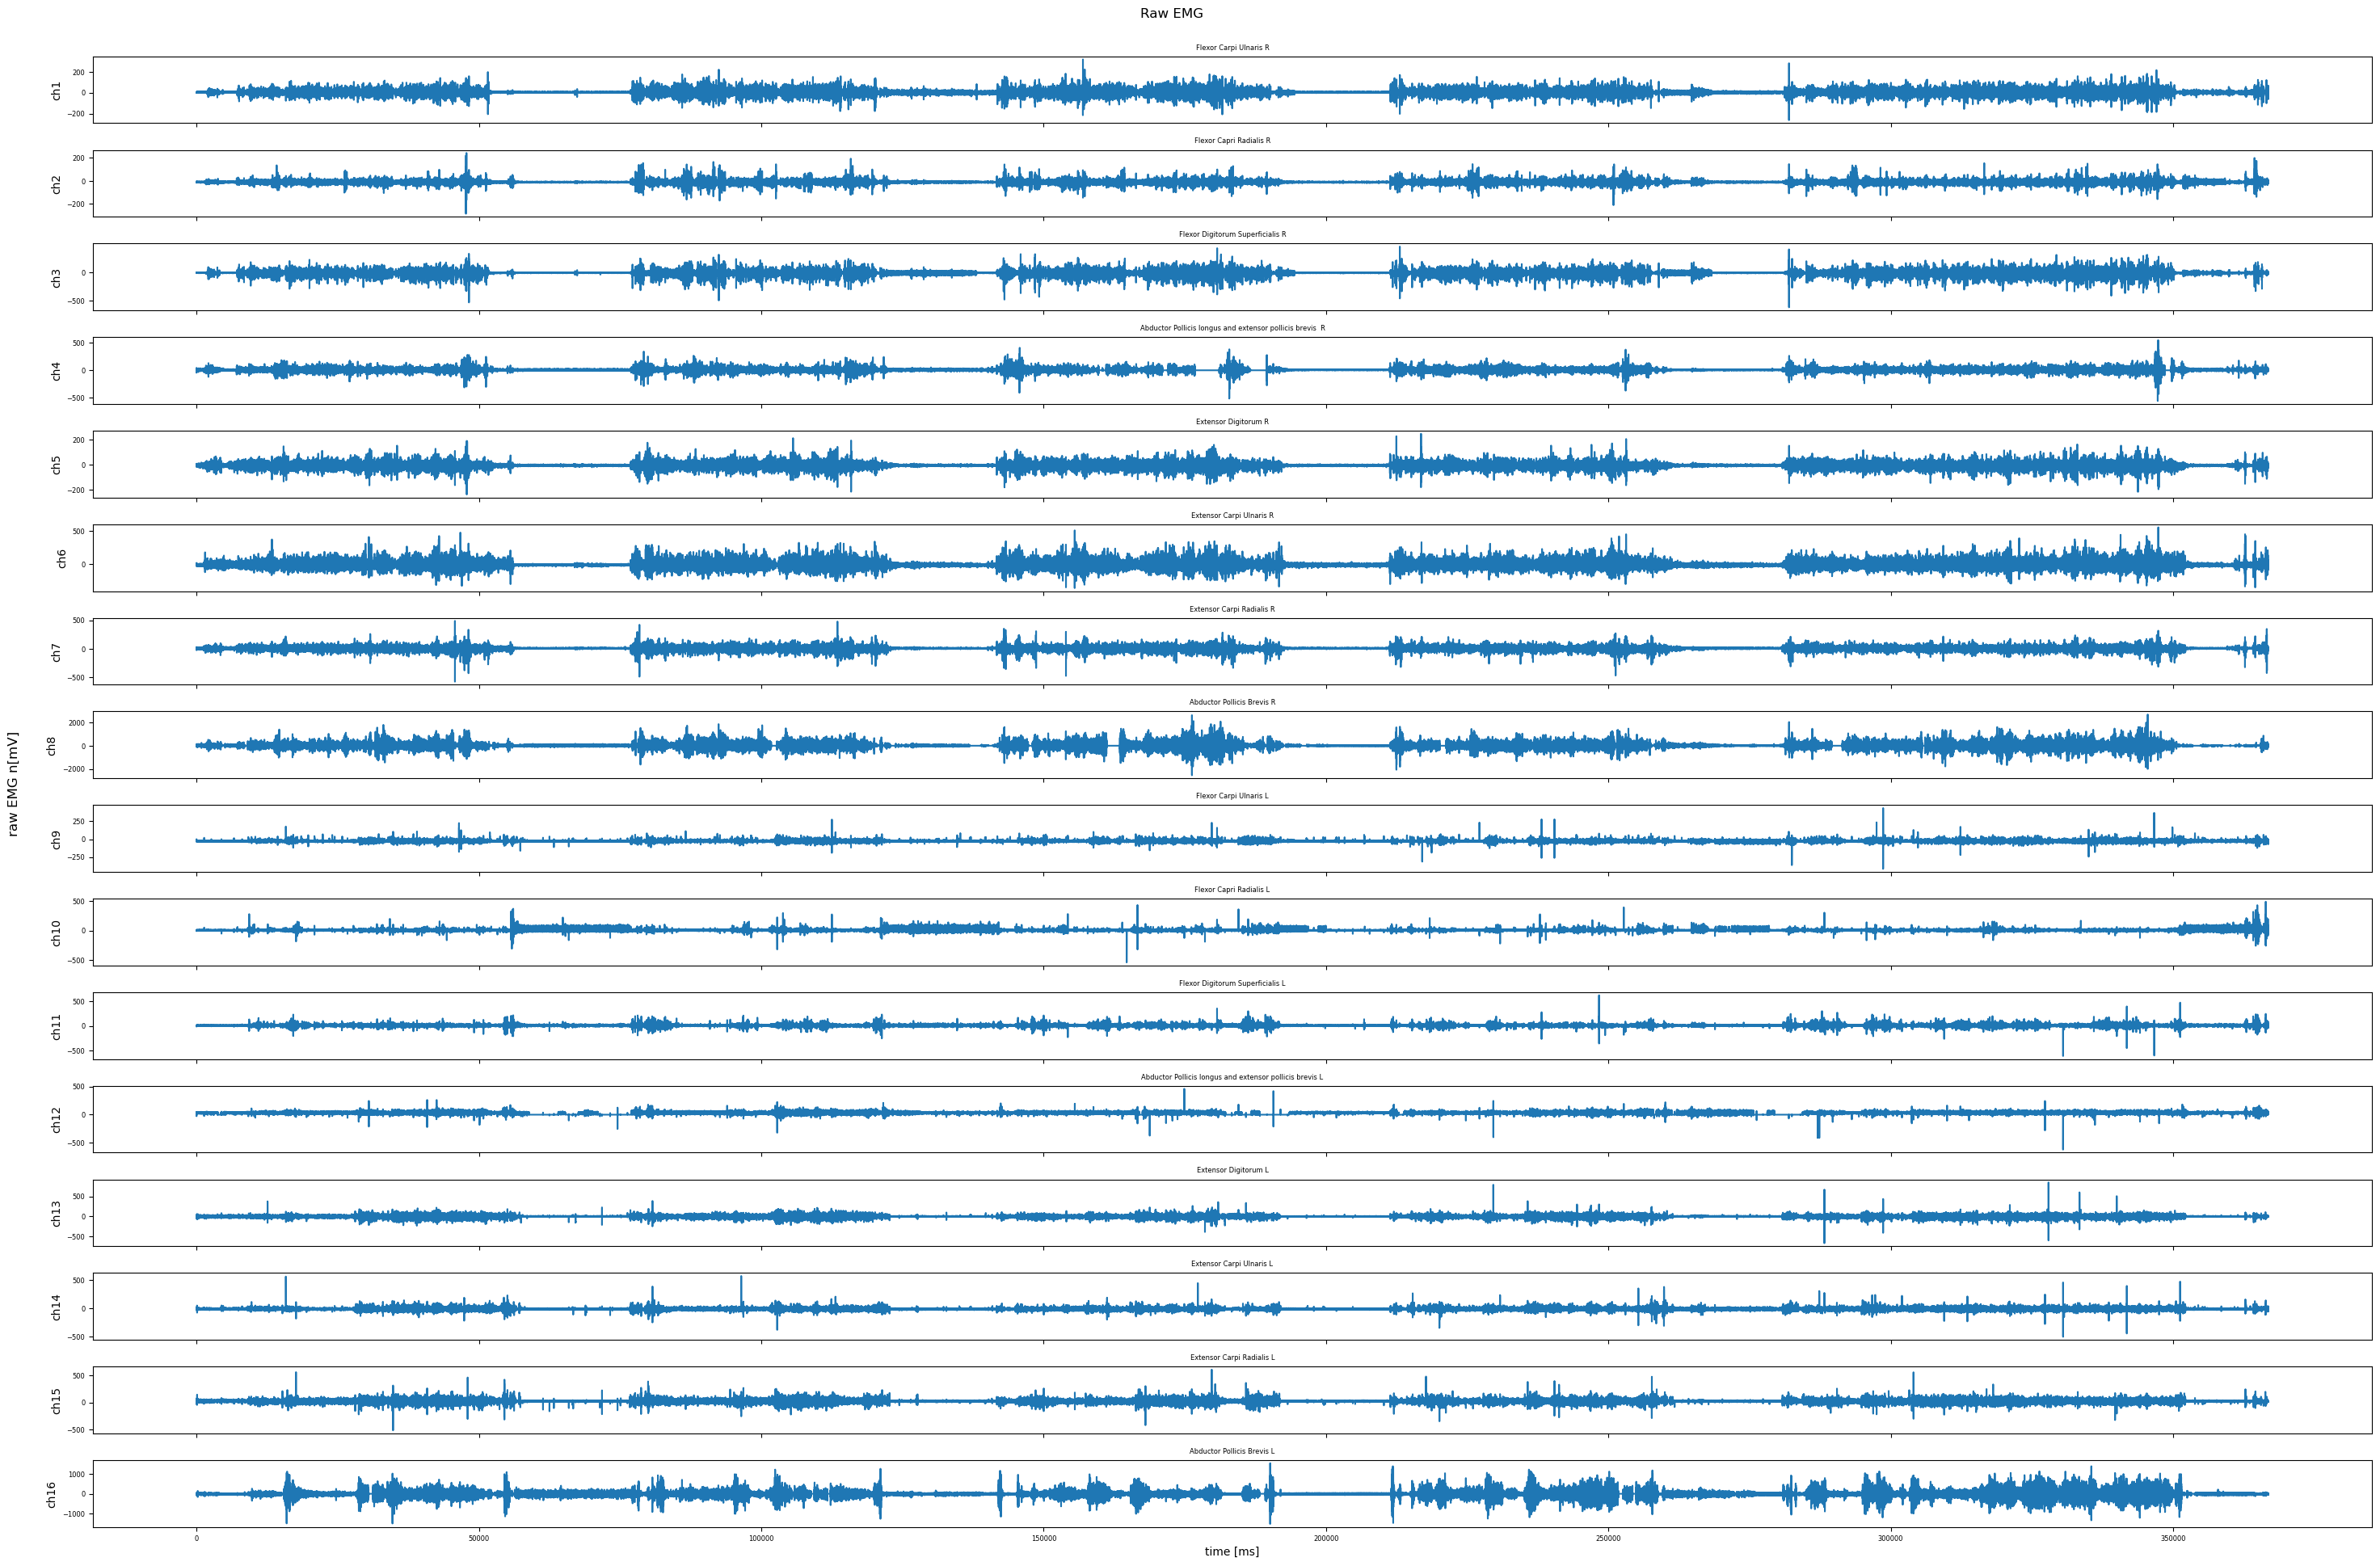

In [4]:
myfct.plot_mydata_raw(path_to_mydata)

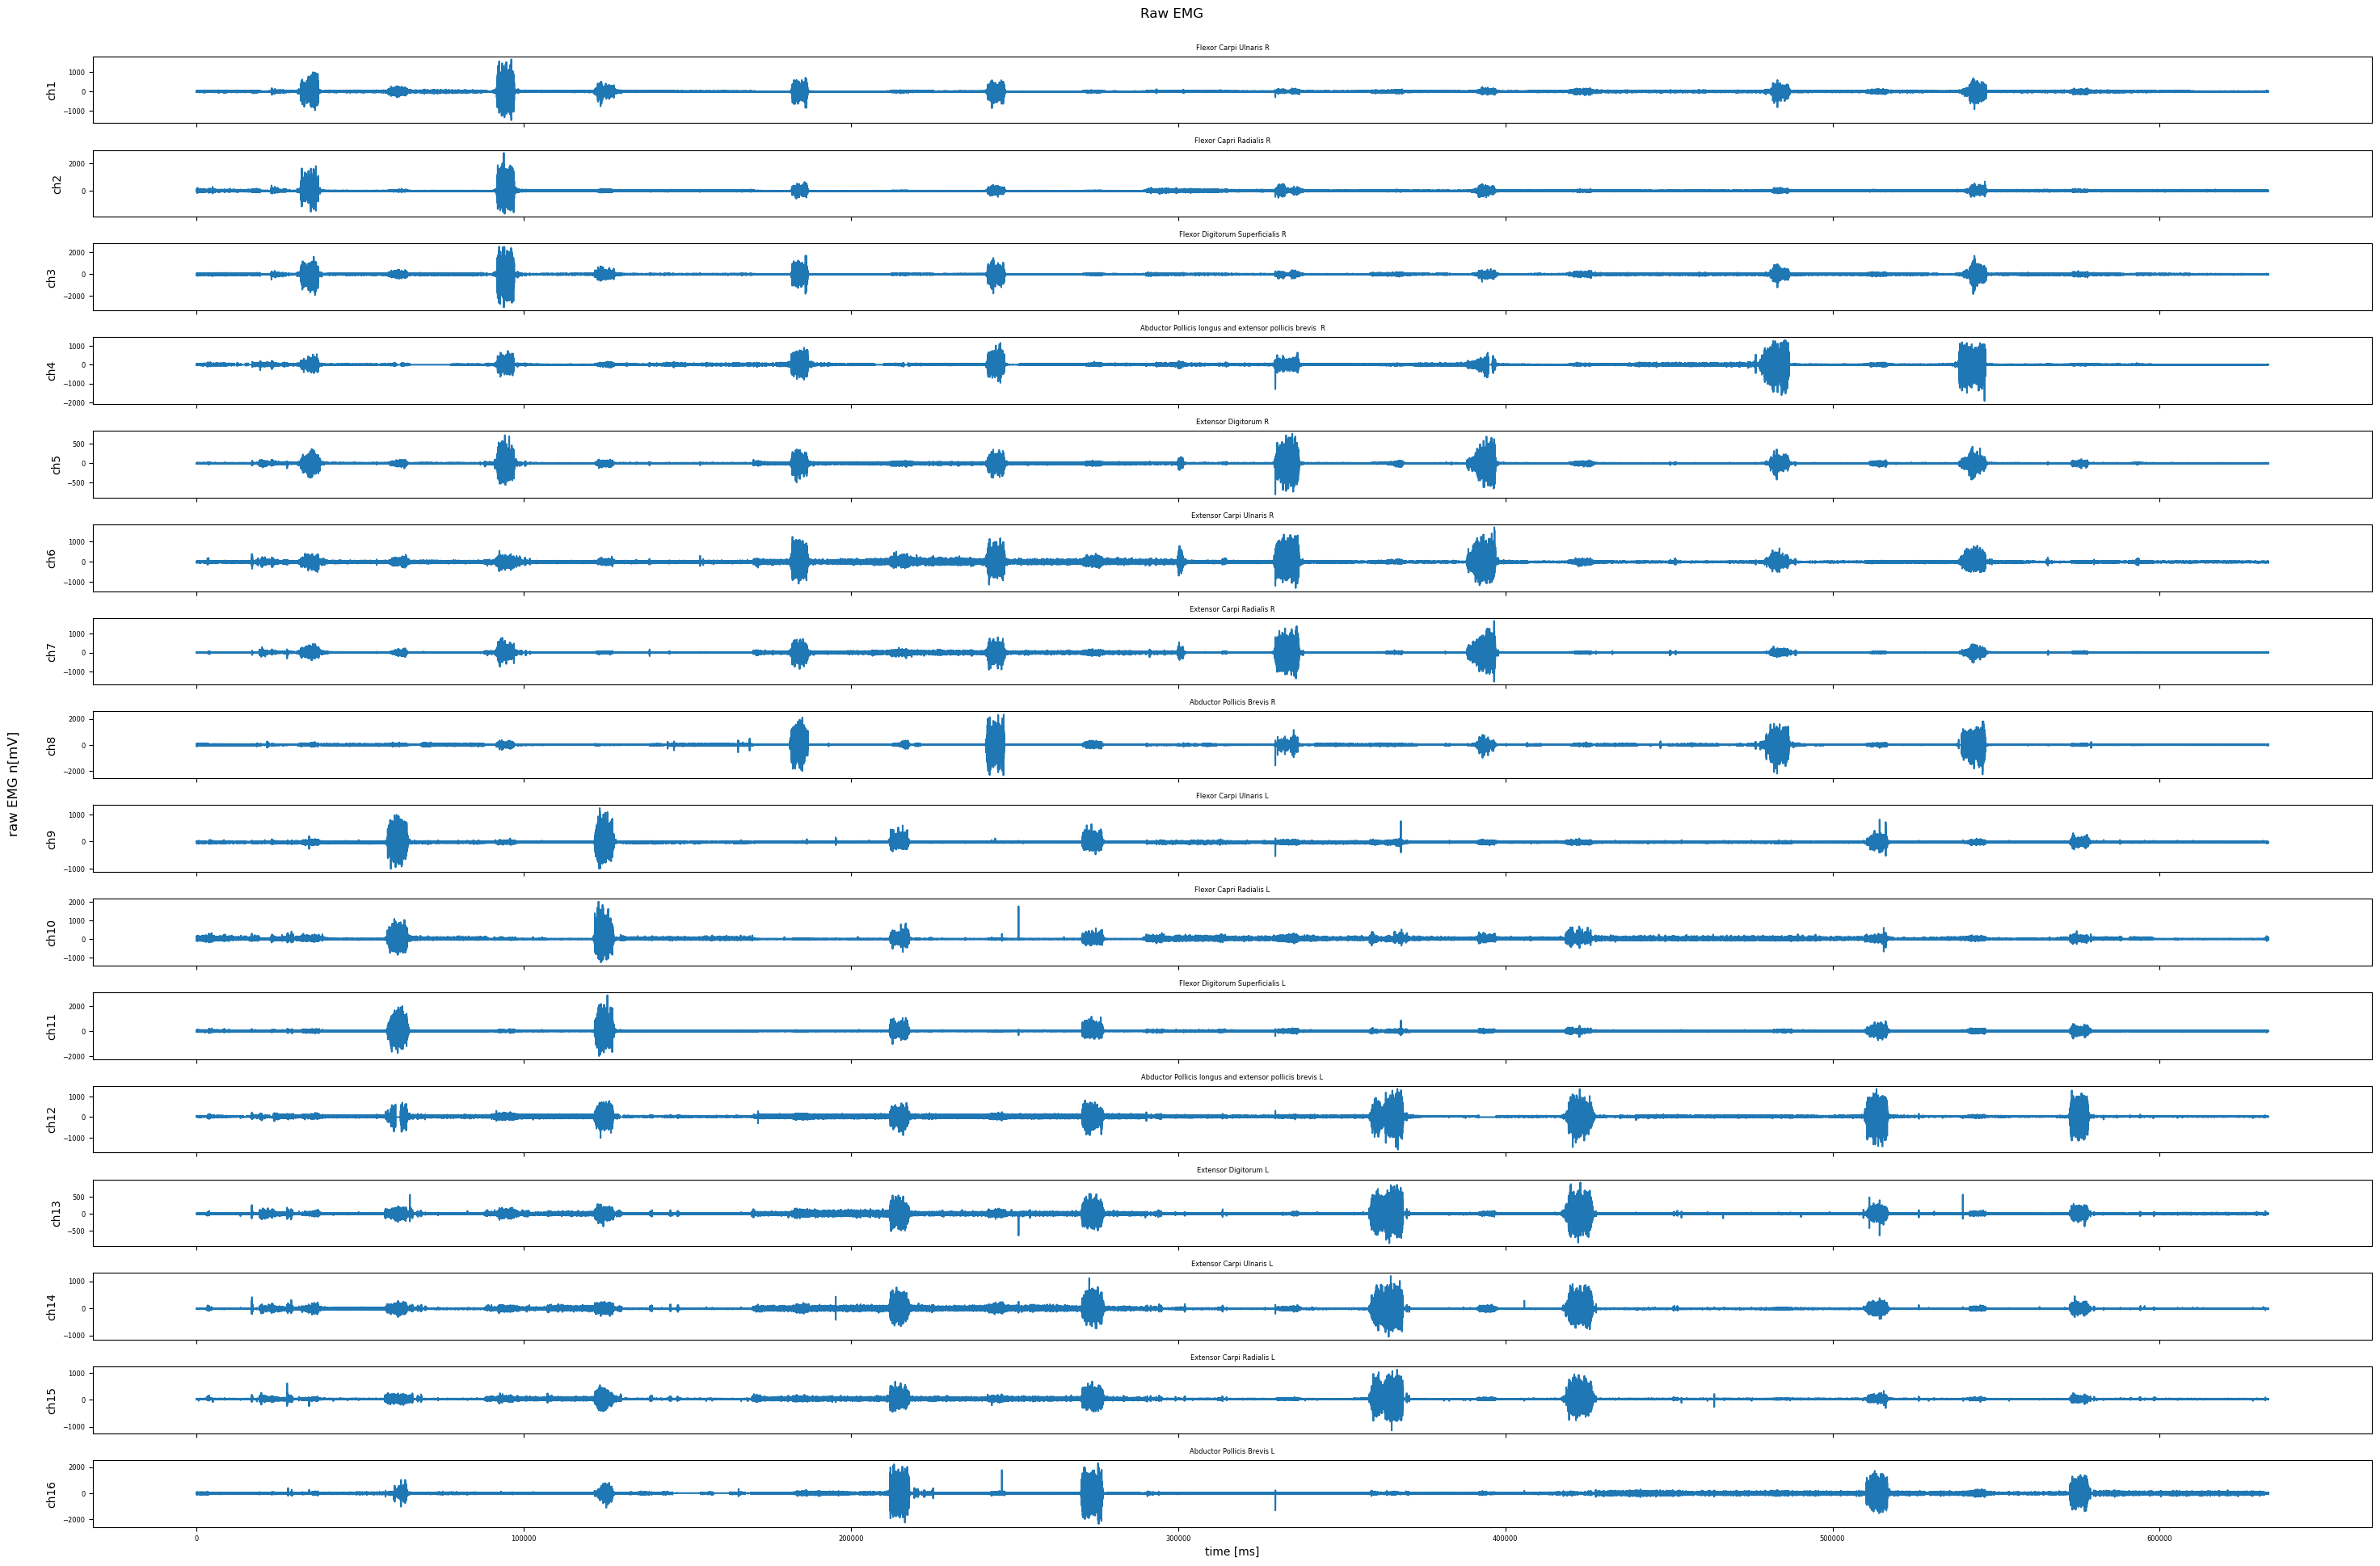

In [5]:
myfct.plot_mydata_raw(path_to_calibration)

## Data after clean_enmg function (right time arrays, remove nan + unexpected high values, remove DC offset, rectify)

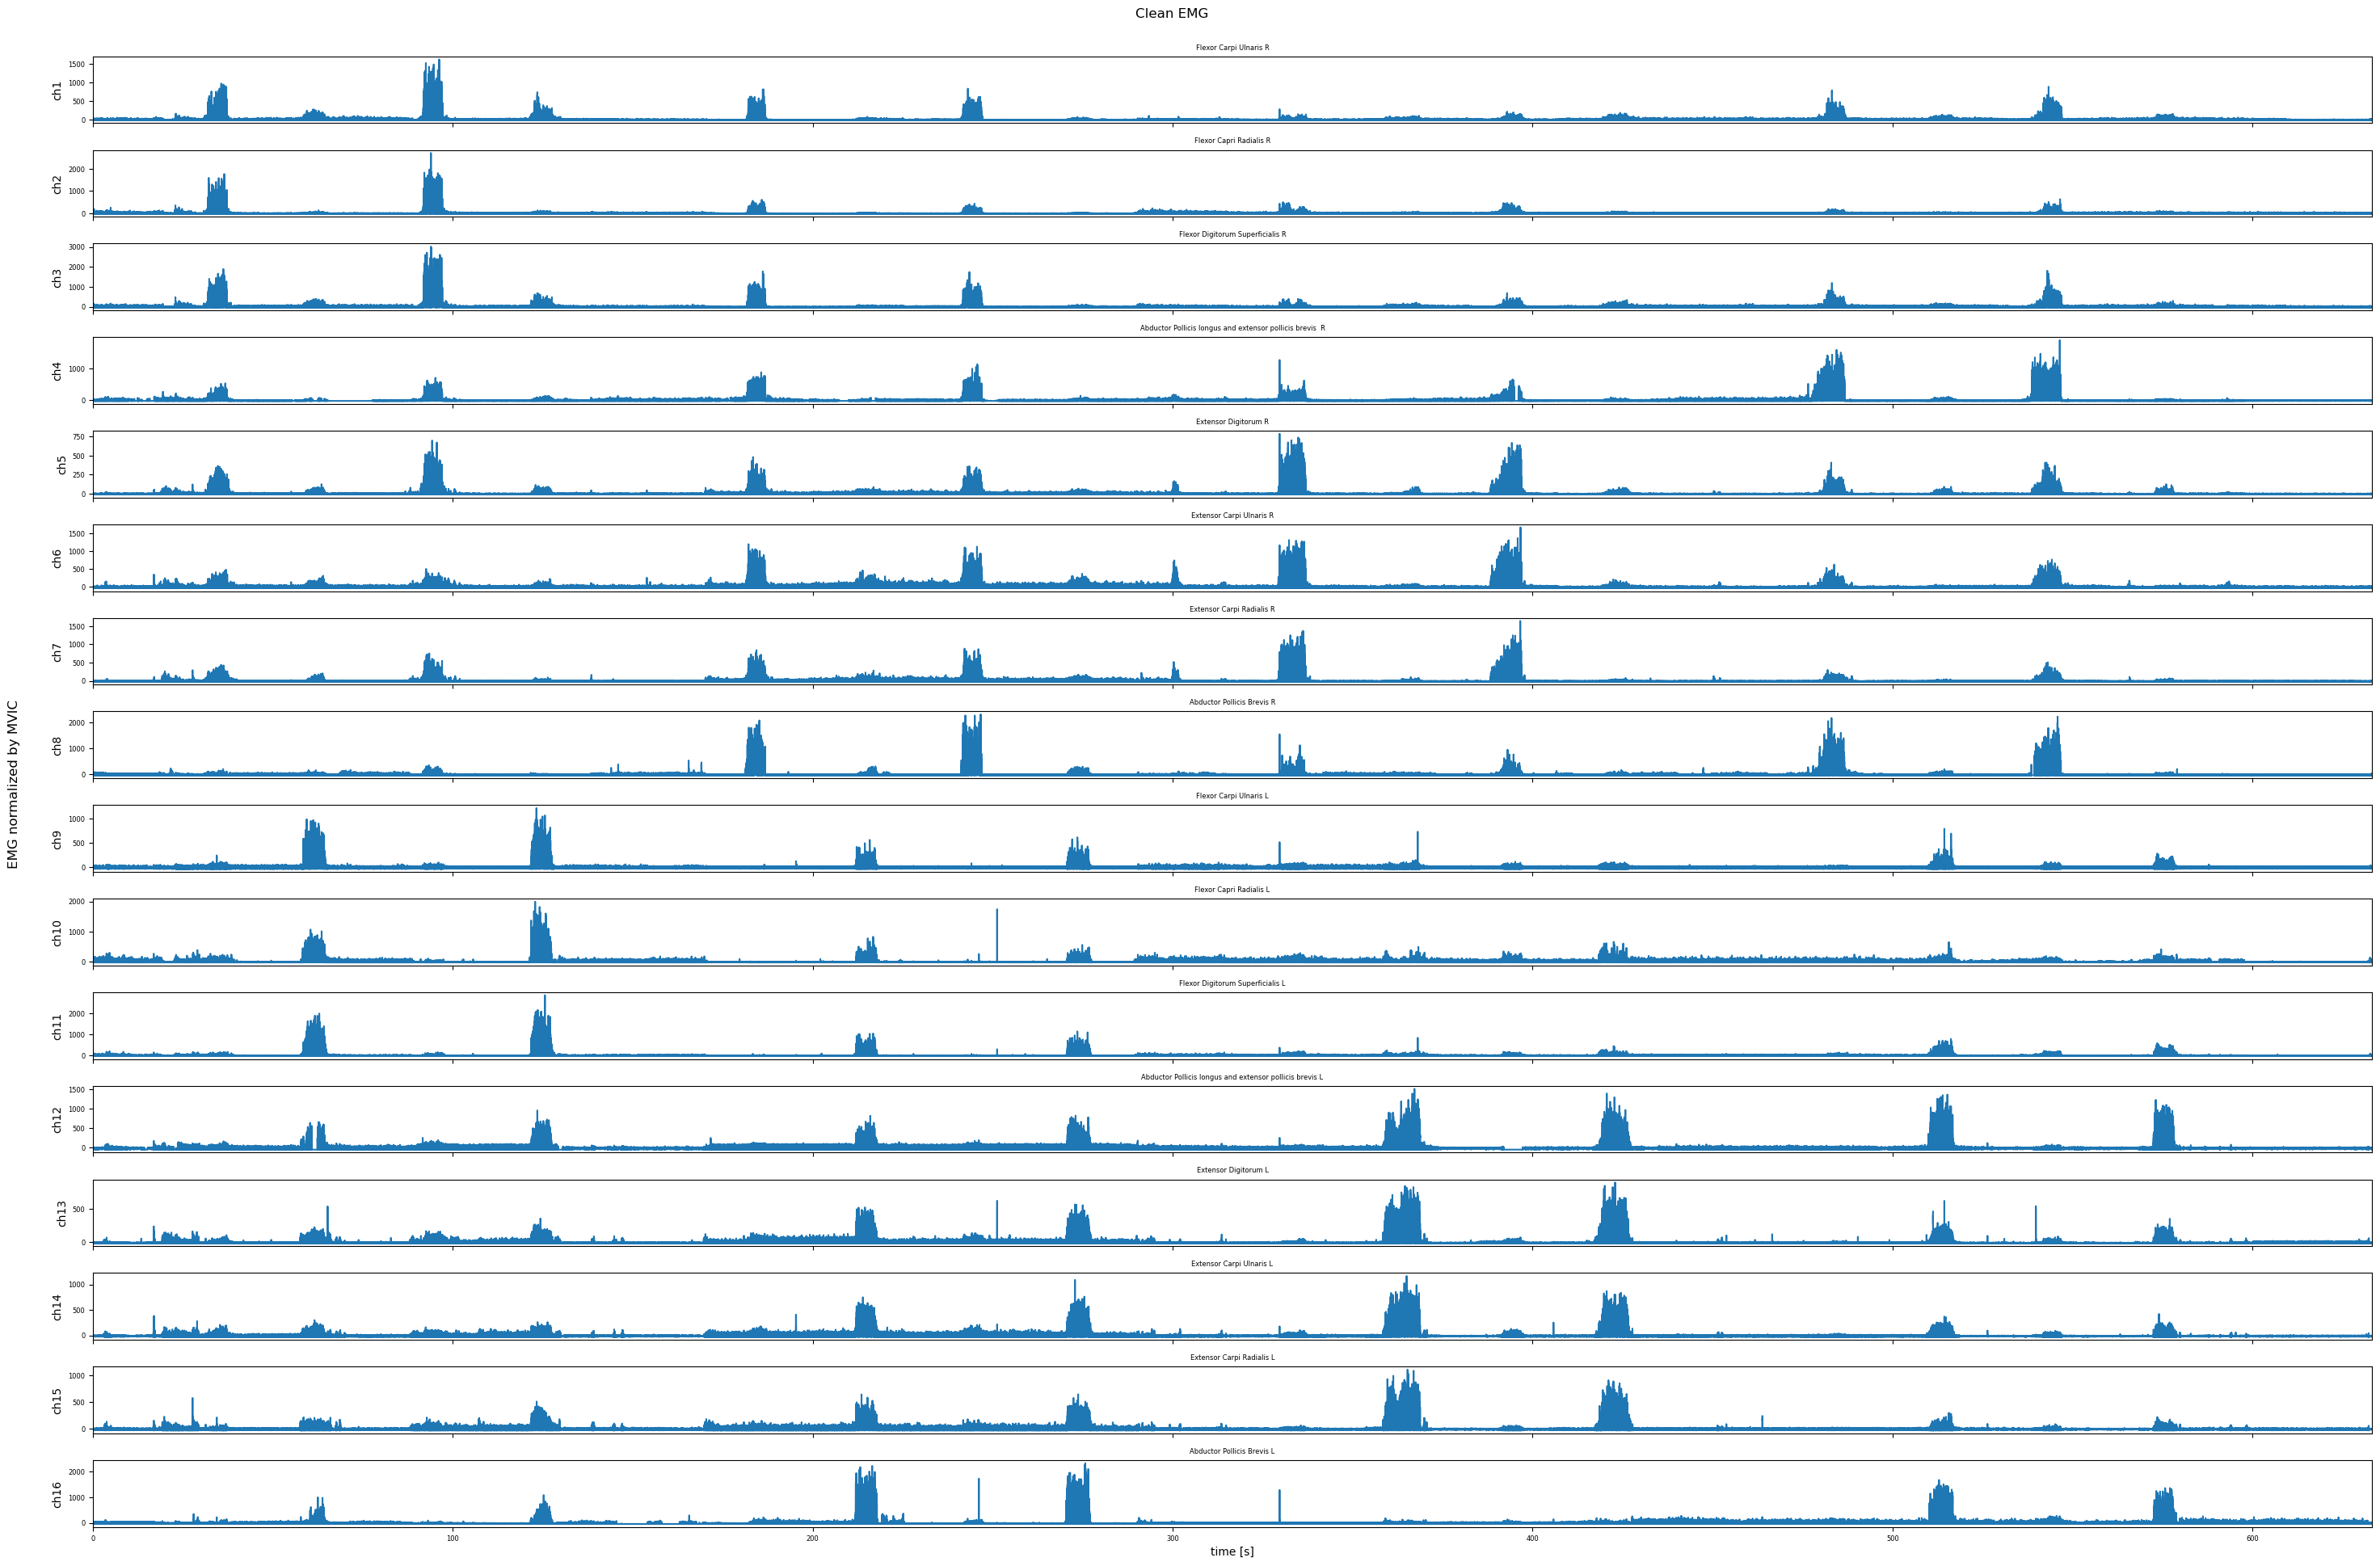

In [6]:
cleanemg_calib = myfct.clean_emg(path_to_calibration, emg_placement)   
cleanemgDF = myfct.clean_emg(path_to_mydata, emg_placement)   

myfct.plot_emgDF(cleanemg_calib)

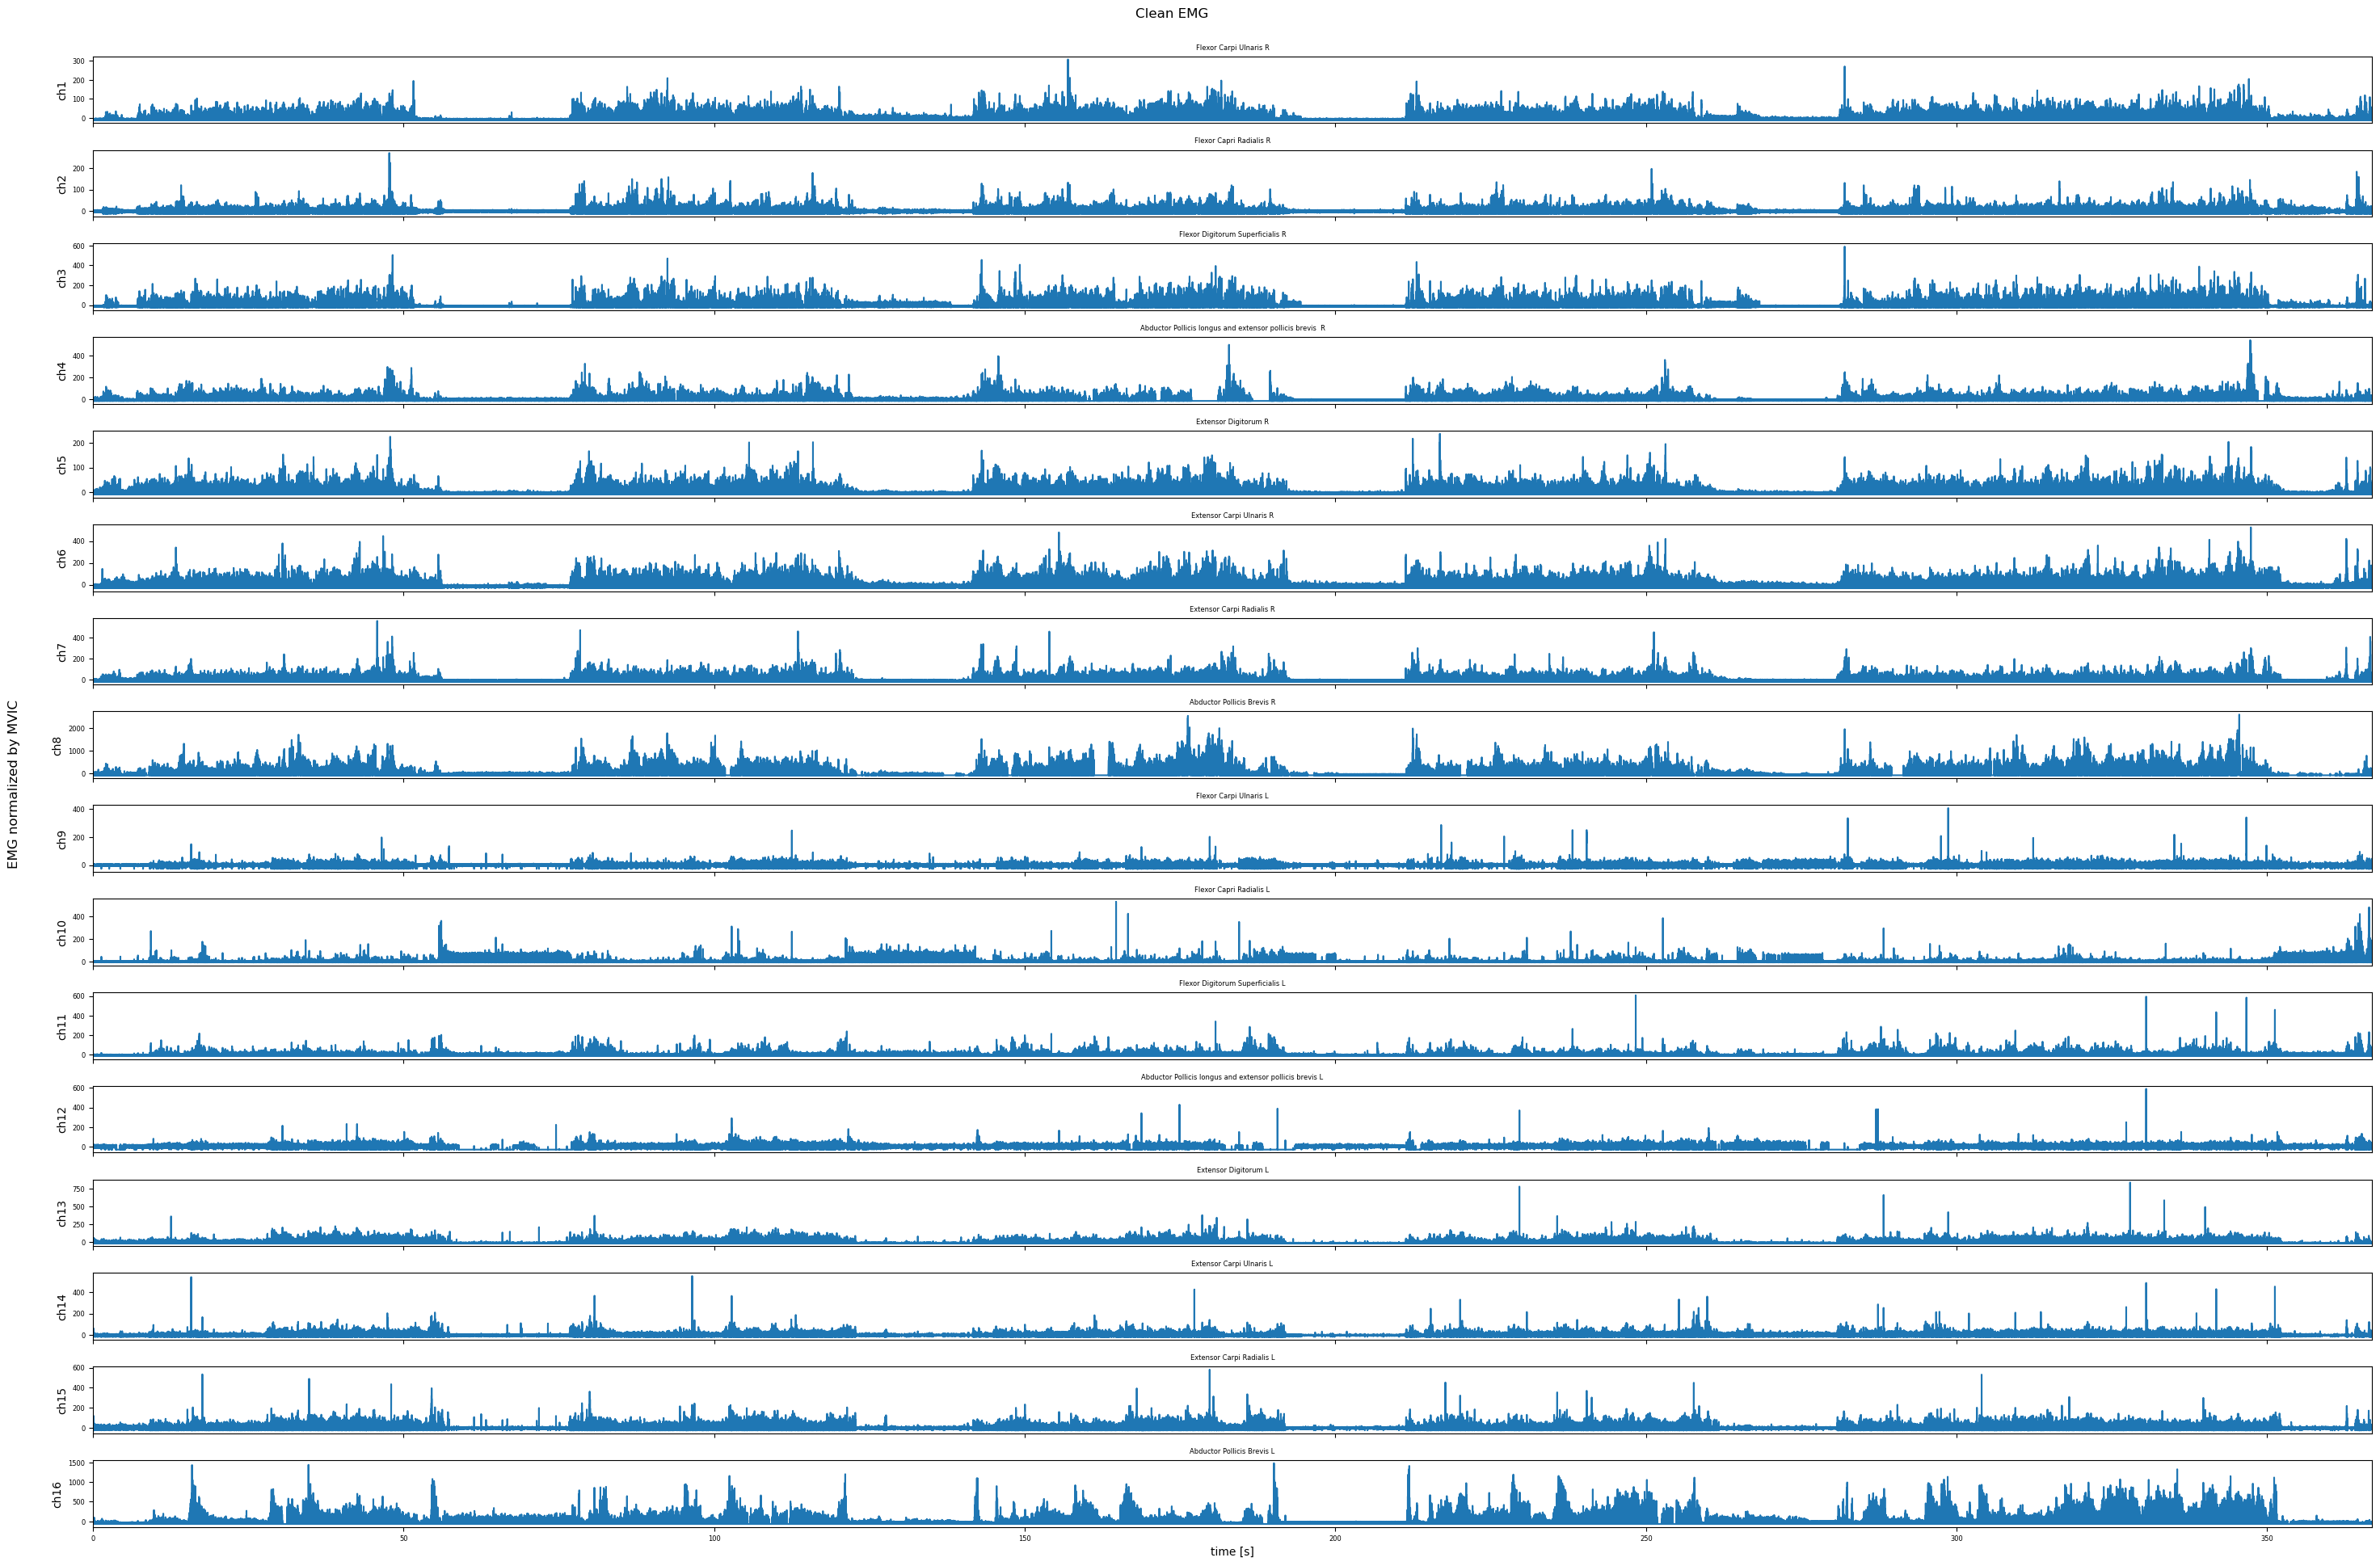

In [7]:
myfct.plot_emgDF(cleanemgDF)

In [8]:
print(f"Calibration recording duration : {cleanemg_calib['relative time'].iloc[-1]:.2f} s")
print(f"Recording duration : {cleanemgDF['relative time'].iloc[-1]:.2f} s")

Calibration recording duration : 633.21 s
Recording duration : 366.85 s


## Filters

### Butterworth

In [9]:
butt_calib = myfct.butterworth_filter(cleanemg_calib)
butt = myfct.butterworth_filter(cleanemgDF)

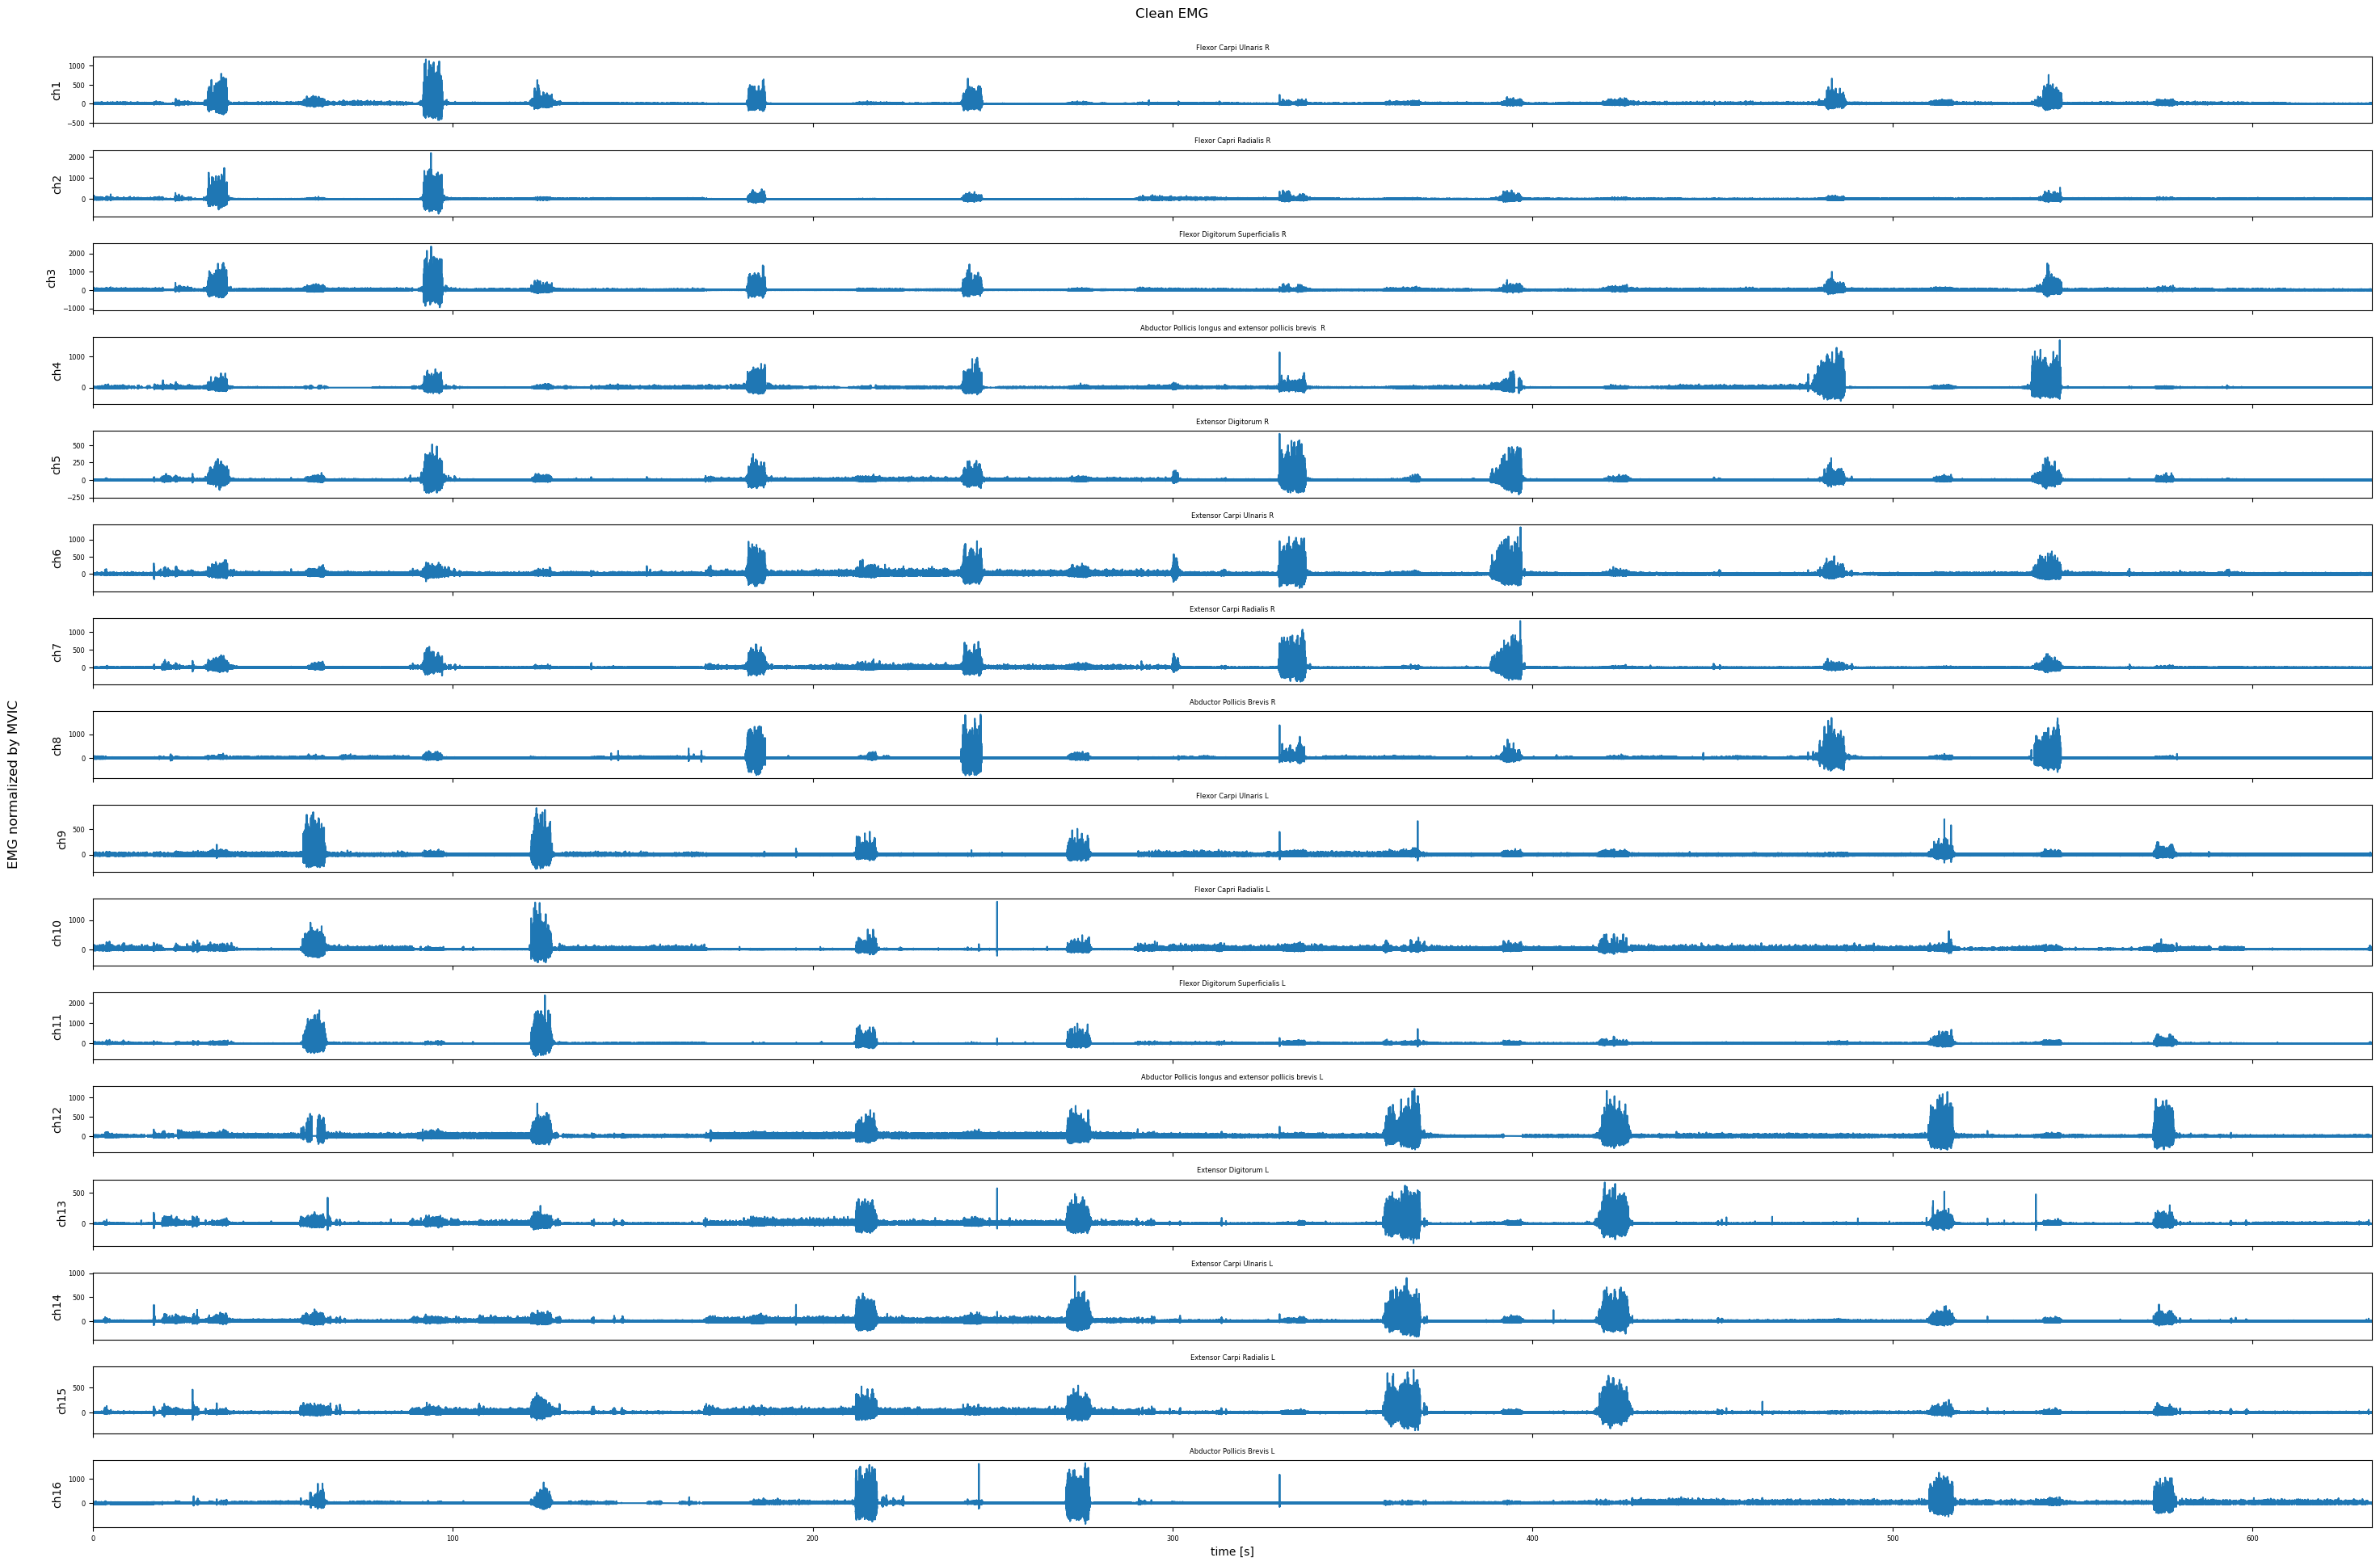

In [10]:
myfct.plot_emgDF(butt_calib)

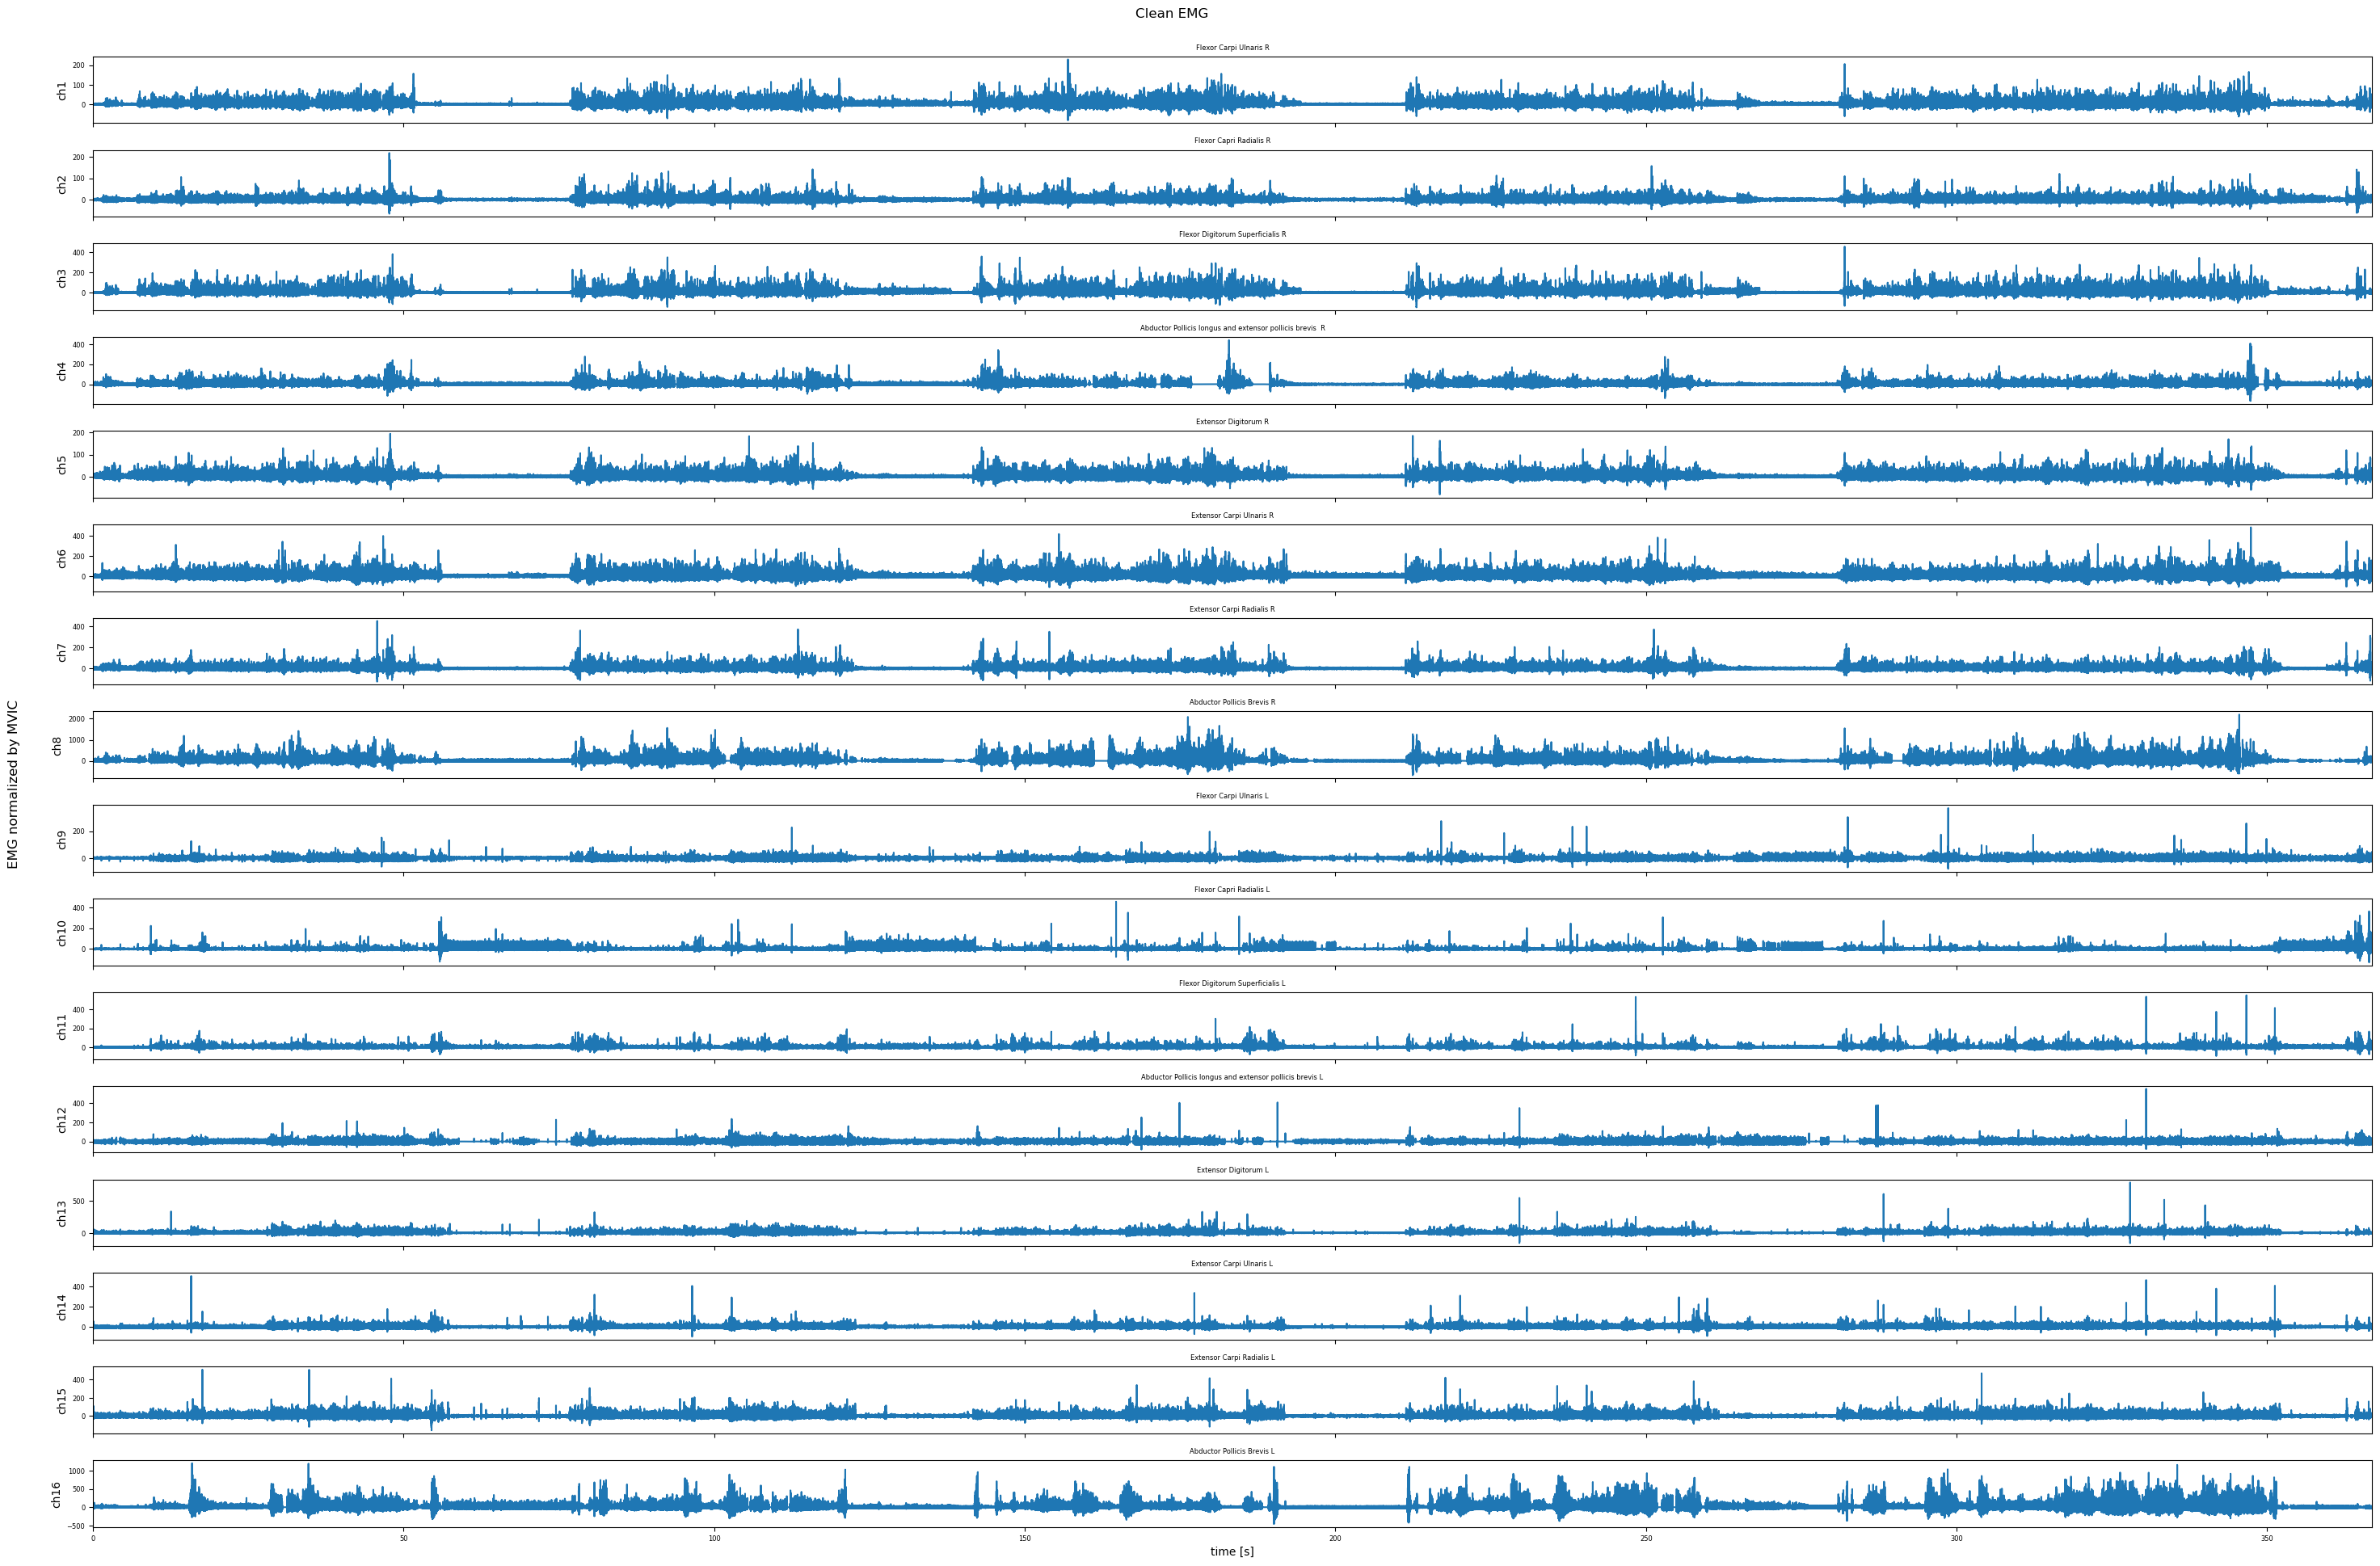

In [11]:
myfct.plot_emgDF(butt)

### Interpolation and rectification

In [12]:
interp_calib = myfct.interpolate_clean_emg(butt_calib, start_idx=0)
interp_calib = abs(interp_calib) #rectify 

interpDF = myfct.interpolate_clean_emg(butt, start_idx=50)
interpDF = abs(interpDF) # rectify

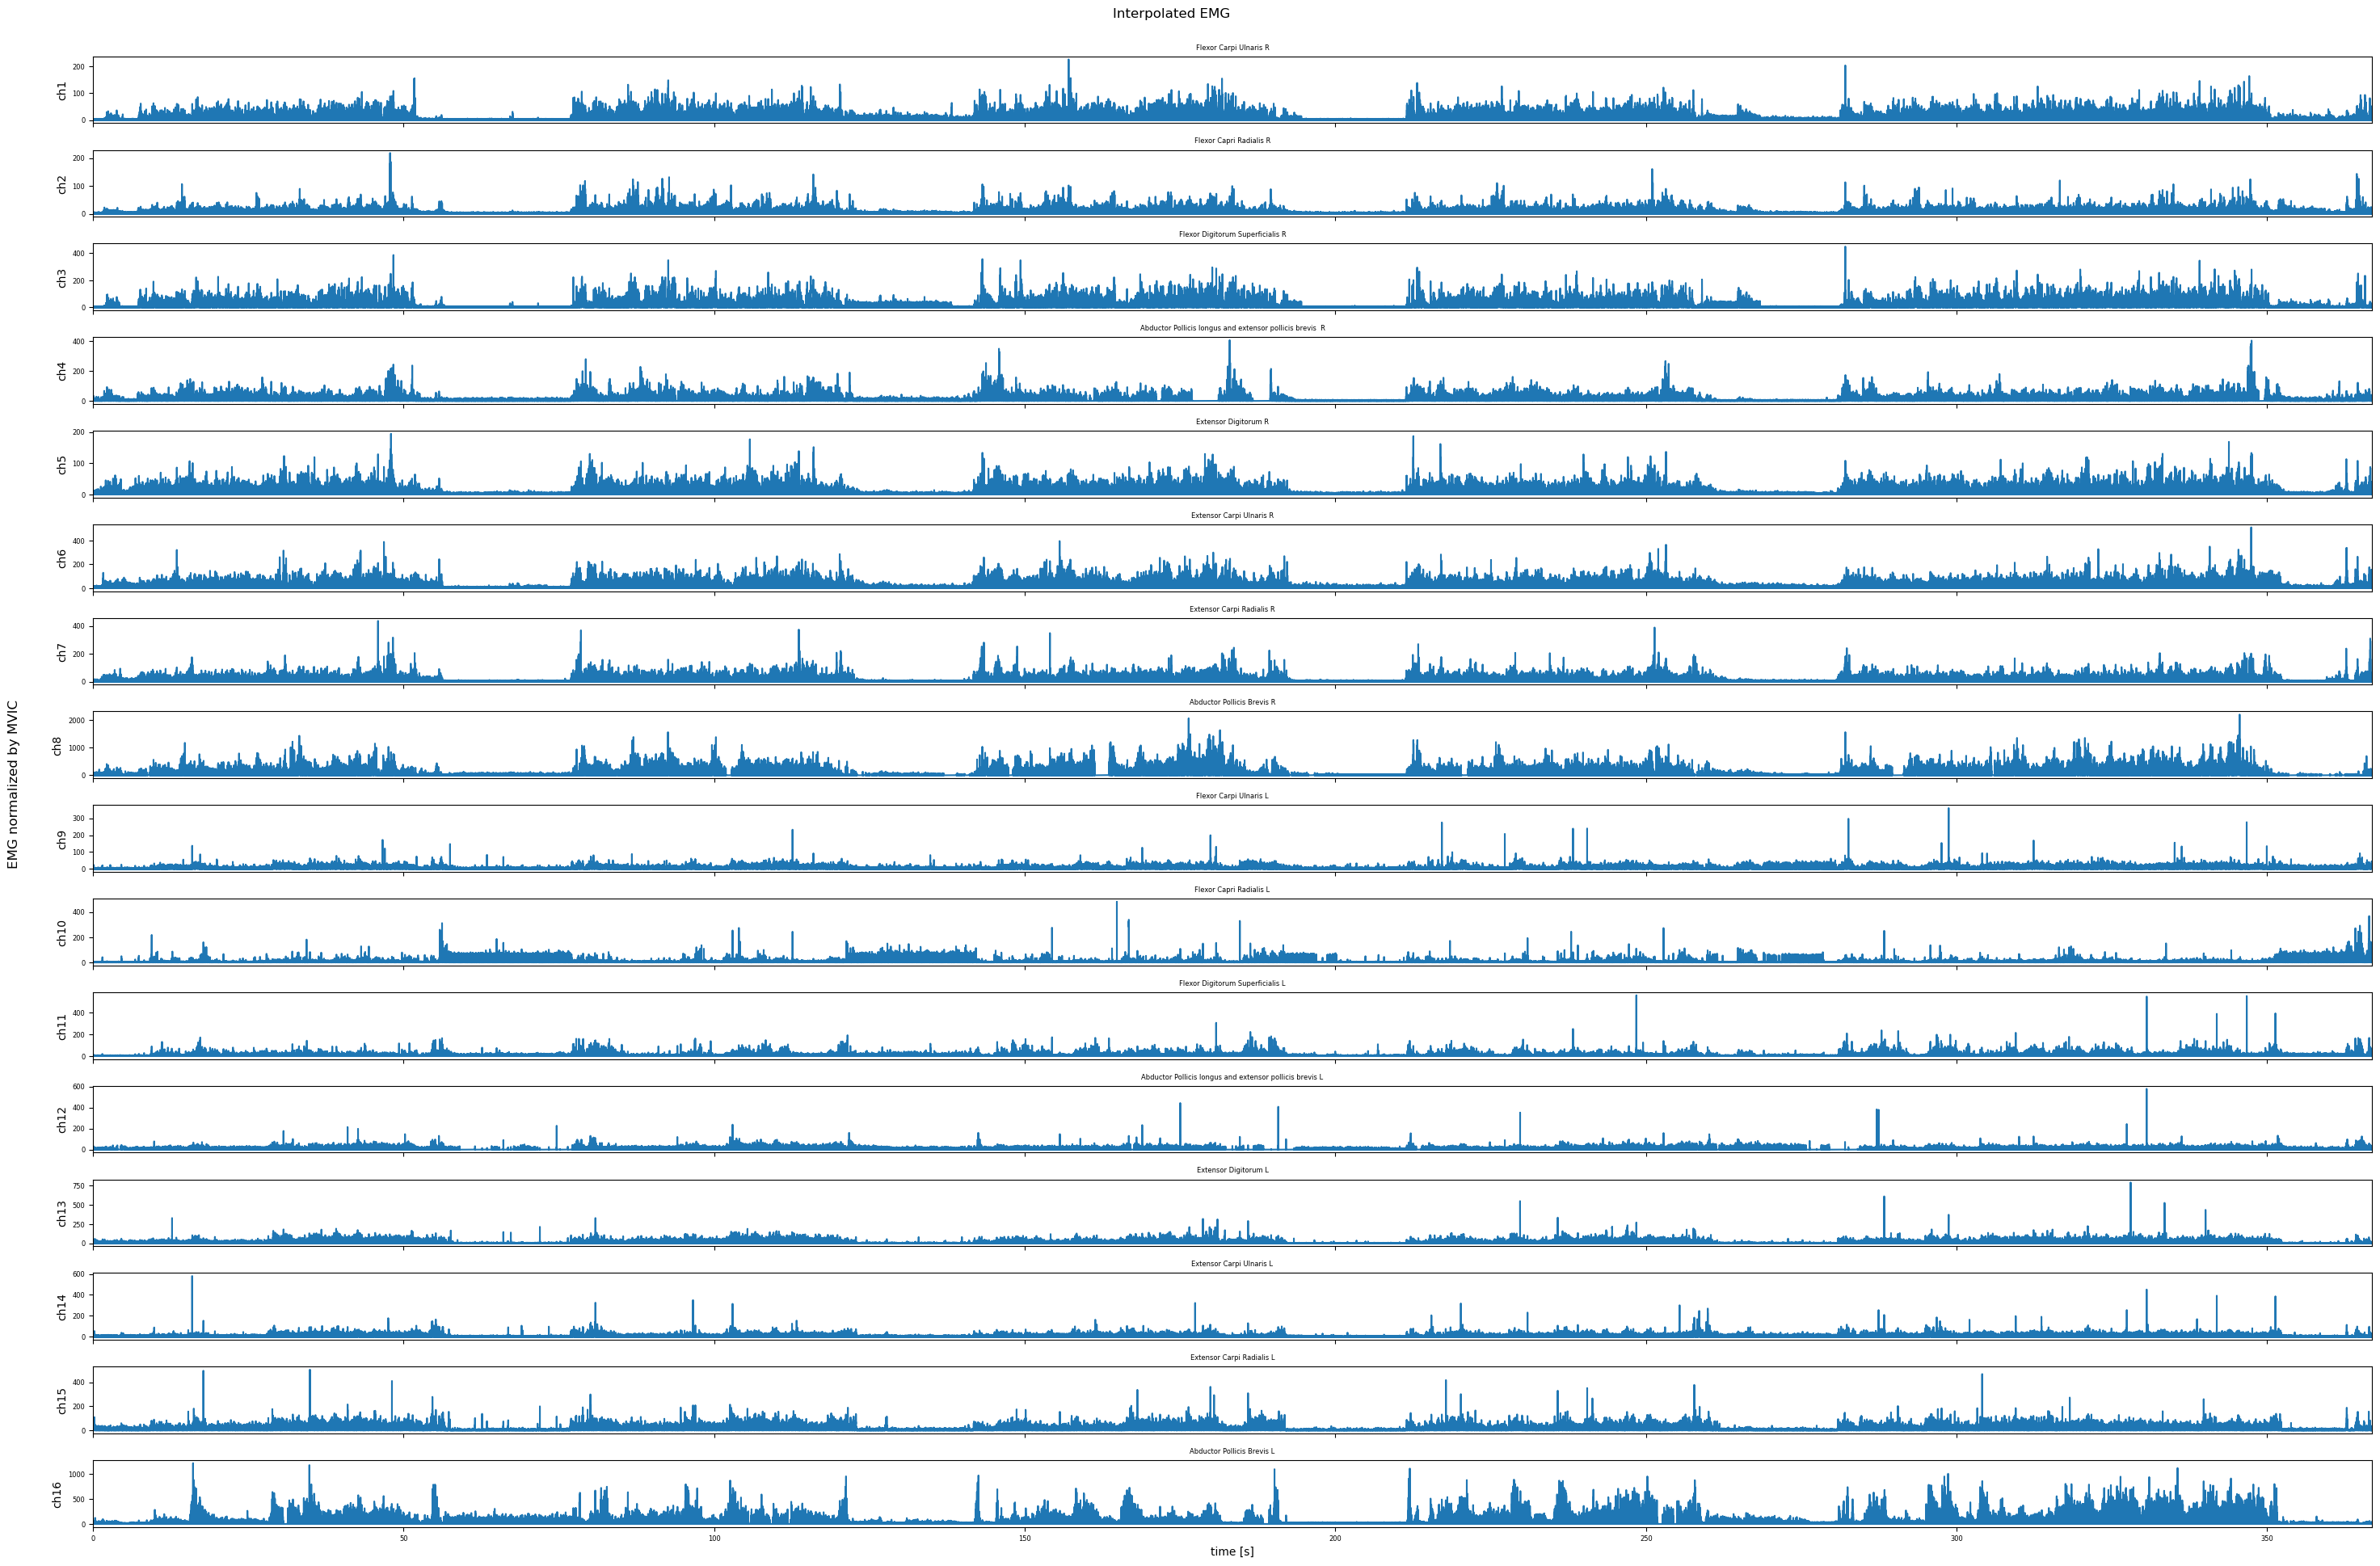

In [13]:
myfct.plot_emgDF(interpDF, title_str='Interpolated EMG')

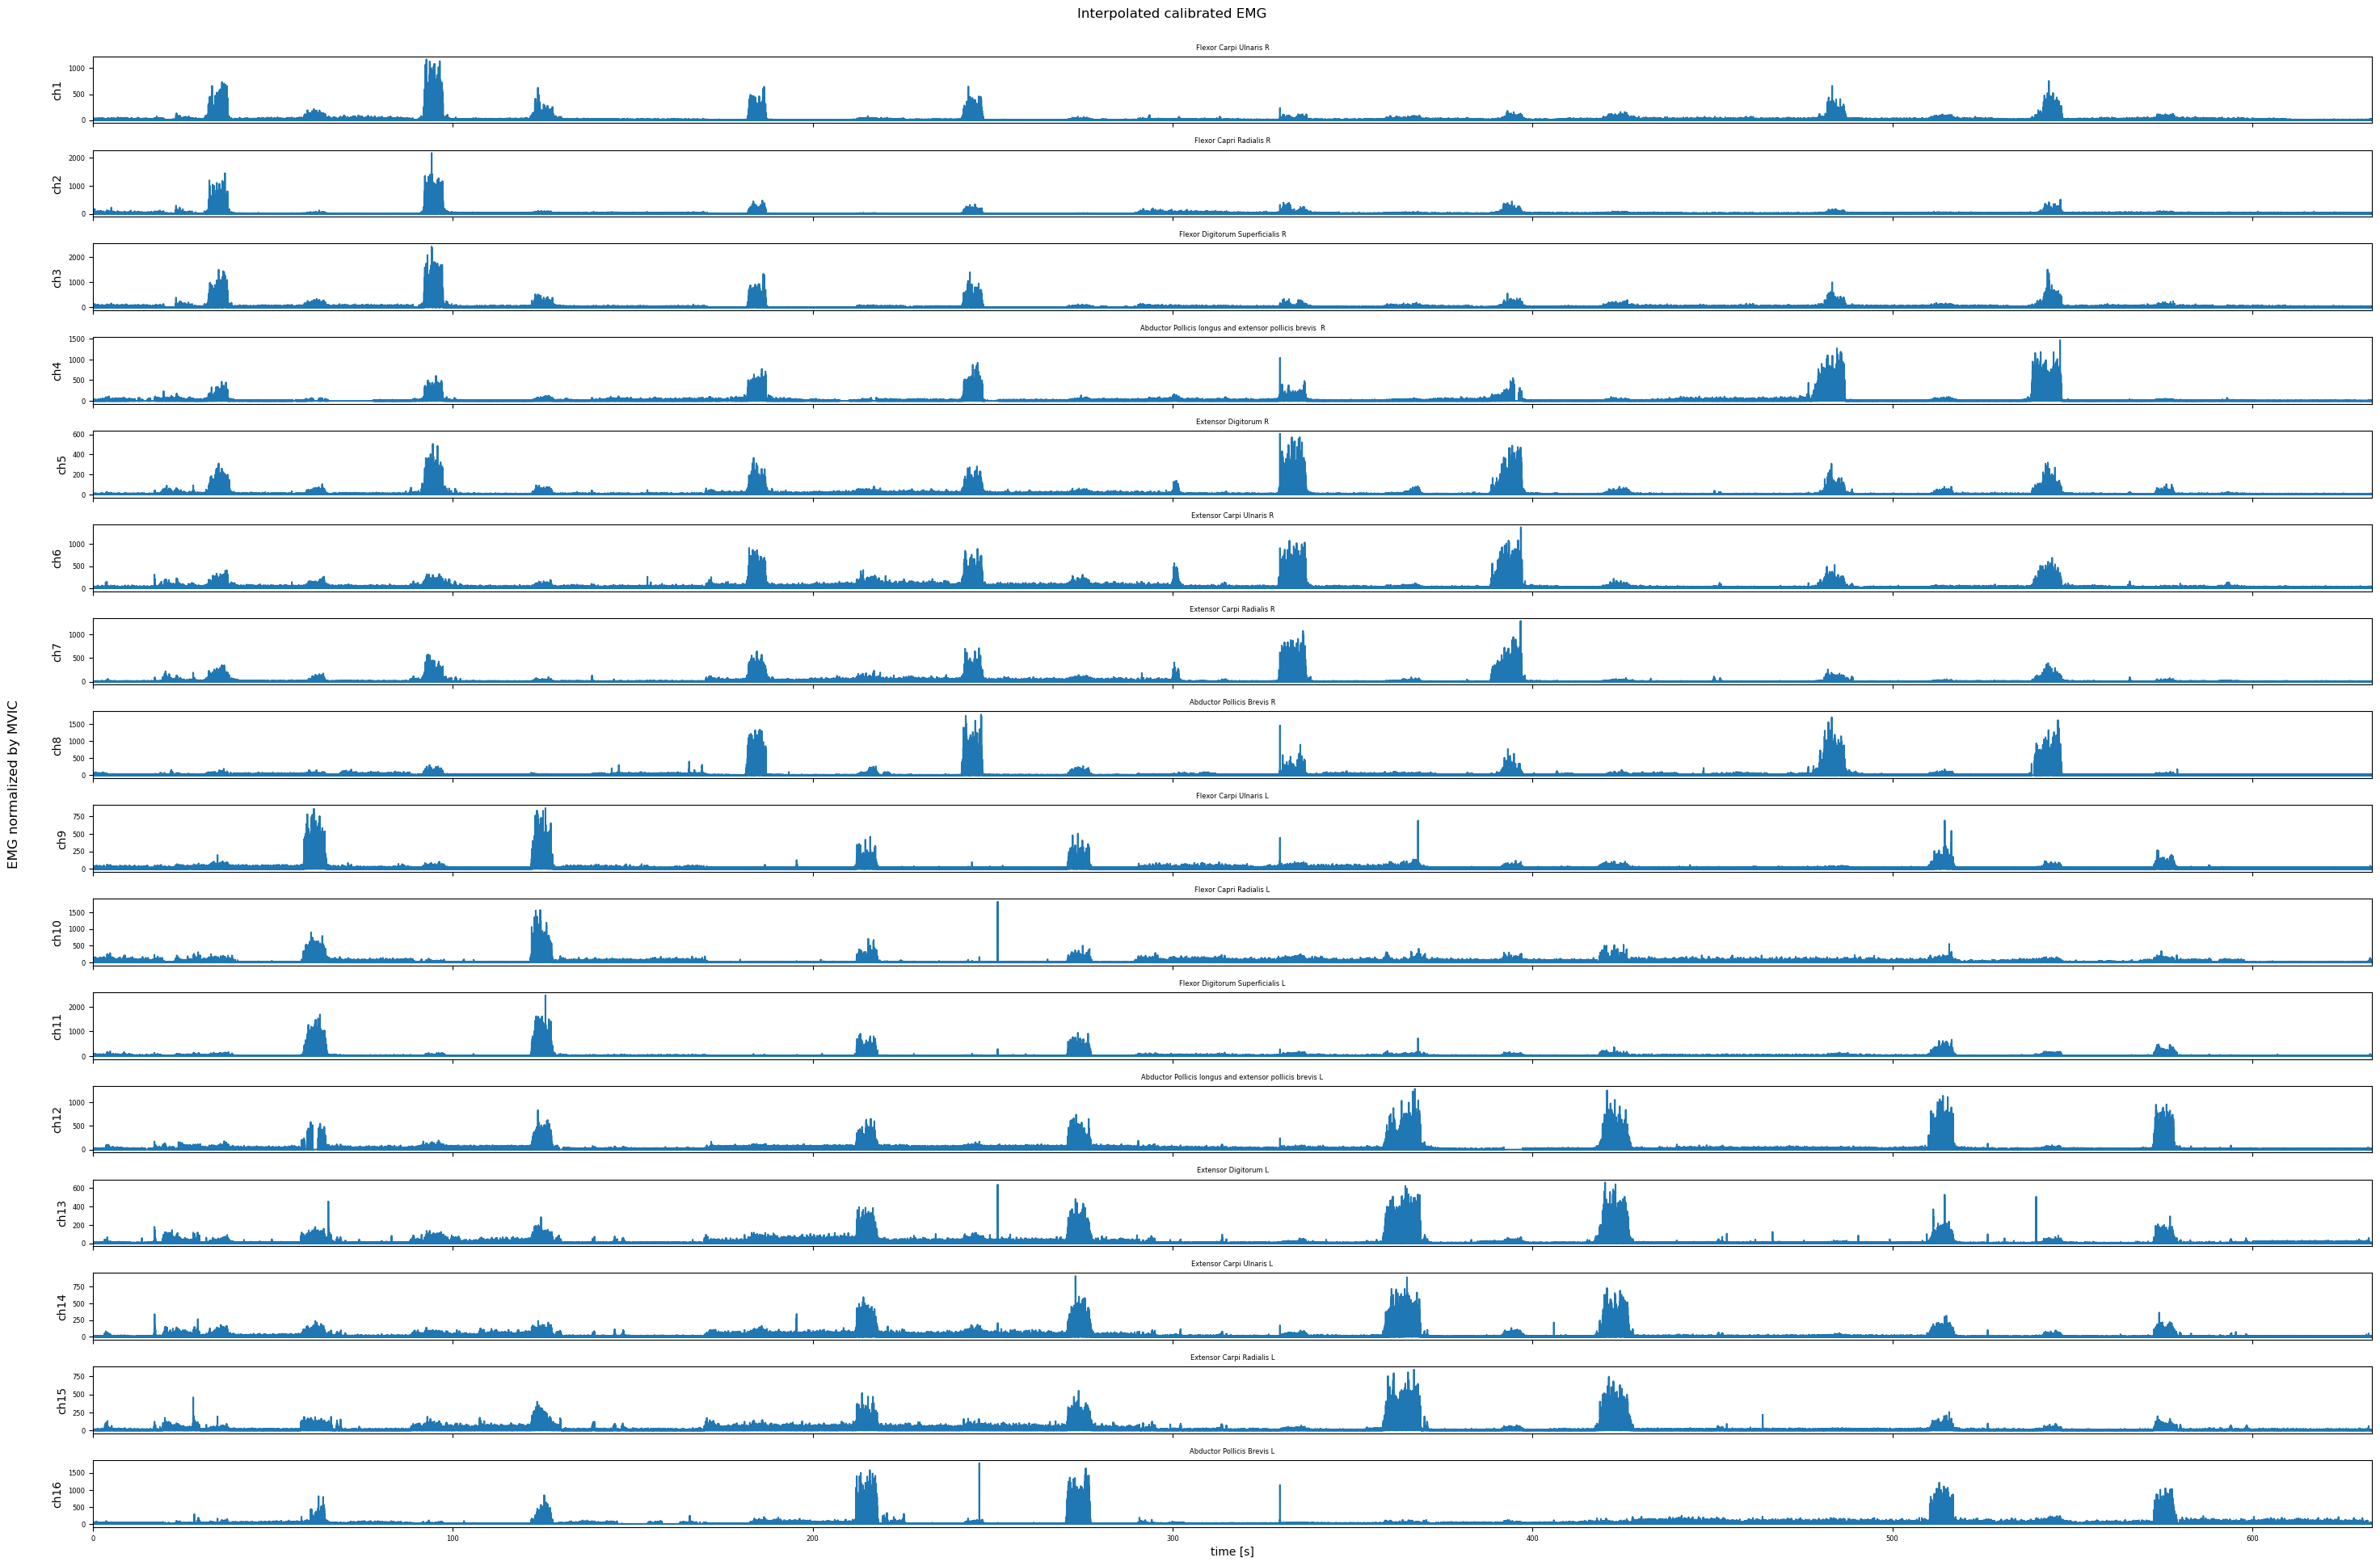

In [14]:
myfct.plot_emgDF(interp_calib, title_str='Interpolated calibrated EMG')

### Test of rms 

In [15]:
rms_calib = myfct.rms_filter(interp_calib)

### Amplitude normalization 

In [16]:
norm_calib = myfct.normalization(interp_calib, interp_calib) #just to verify
normDF = myfct.normalization(interpDF, interp_calib)

### Plotting the filters 

In [17]:
idx_label_studied = 15
label_studied = cleanemg_calib.columns.values.tolist()[idx_label_studied]

C:\Users\cabasse\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



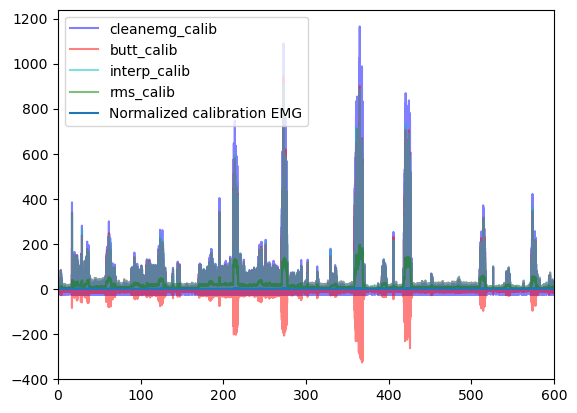

In [18]:
plt.plot(cleanemg_calib["relative time"], cleanemg_calib[label_studied], color= 'b', label = "cleanemg_calib", alpha = 0.5)
plt.plot(butt_calib["relative time"], butt_calib[label_studied], color= 'r', label = "butt_calib", alpha = 0.5)
plt.plot(interp_calib["relative time"], interp_calib[label_studied], color= 'c', label = "interp_calib", alpha = 0.5)
plt.plot(rms_calib["relative time"], rms_calib[label_studied], color= 'g', label = "rms_calib", alpha = 0.5)
plt.plot(norm_calib["relative time"], norm_calib[label_studied], label='Normalized calibration EMG')

plt.legend()
plt.xlim([0, 600])
plt.show()

## Feature extraction

In [19]:
labels_list = cleanemg_calib.columns.values.tolist()

### Linear envelope: creates lowpass filter and apply to rectified signal to get EMG envelope

In [20]:
low_pass = 8/(SR/2) #8Hz is the Fc
b2, a2 = sp.butter(4, low_pass, btype='lowpass')
envelopeDF = normDF.copy()
for label in labels_list[2:]:
    envelopeDF[label] = sp.filtfilt(b2, a2, normDF[label].values)

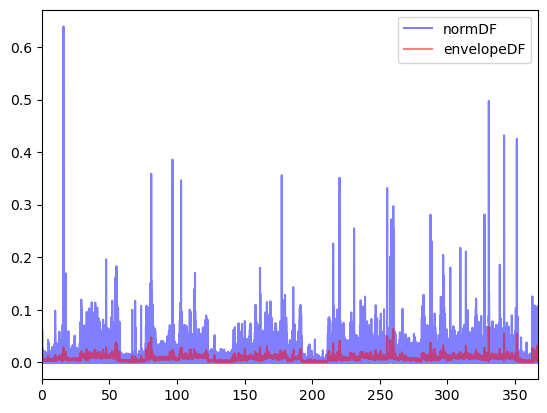

In [21]:
plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(envelopeDF["relative time"], envelopeDF[label_studied], color= 'r', label = "envelopeDF", alpha = 0.5)

plt.legend()
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])
plt.show()

#### Gaussian moving window on linear envelope

In [22]:
gaussDF = envelopeDF.copy() #gaussian smoothing on envelopeDF
for label in labels_list[2:]:
    gaussDF[label] = gaussDF[label].rolling(window = 450, win_type='gaussian', center=True).sum(std=1)

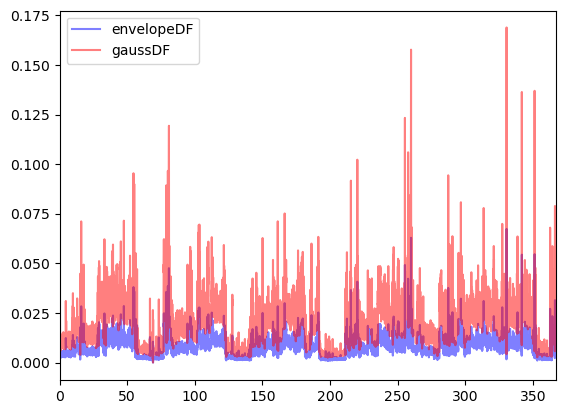

In [23]:
plt.plot(envelopeDF["relative time"], envelopeDF[label_studied], color= 'b', label = "envelopeDF", alpha = 0.5)
plt.plot(gaussDF["relative time"], gaussDF[label_studied], color= 'r', label = "gaussDF", alpha = 0.5)

plt.legend()
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])
plt.show()

#### Hamming moving window on linear envelope

In [24]:
hammDF = envelopeDF.copy()
for label in labels_list[2:]:
    hammDF[label] = hammDF[label].rolling(window = 5, win_type='hamming', center=True).sum()

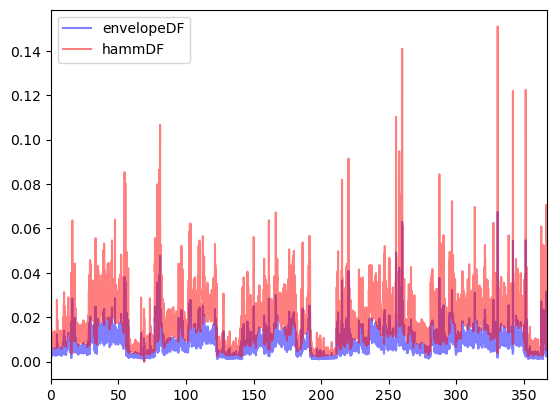

In [25]:
plt.plot(envelopeDF["relative time"], envelopeDF[label_studied], color= 'b', label = "envelopeDF", alpha = 0.5)
plt.plot(hammDF["relative time"], hammDF[label_studied], color= 'r', label = "hammDF", alpha = 0.5)
plt.legend()
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])
plt.show()

### RMS

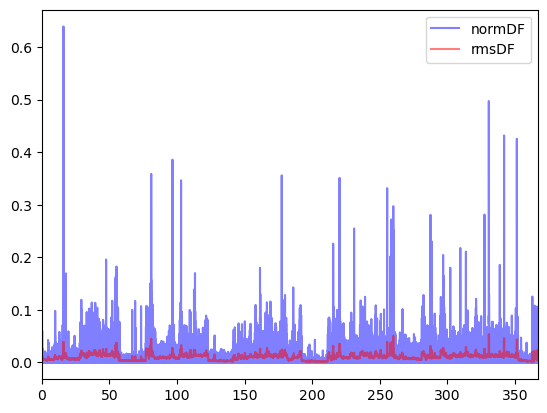

In [26]:
rmsDF = myfct.rms_filter(normDF)

plt.plot(normDF["relative time"], normDF[label_studied], color= 'b', label = "normDF", alpha = 0.5)
plt.plot(rmsDF["relative time"], rmsDF[label_studied], color= 'r', label = "rmsDF", alpha = 0.5)

plt.legend()
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])
plt.show()

### Power spectrum of the normalized dataframe

Peak height of power spectrum = 0.0074 Hz


Text(0, 0.5, 'Linear spectrum [V RMS]')

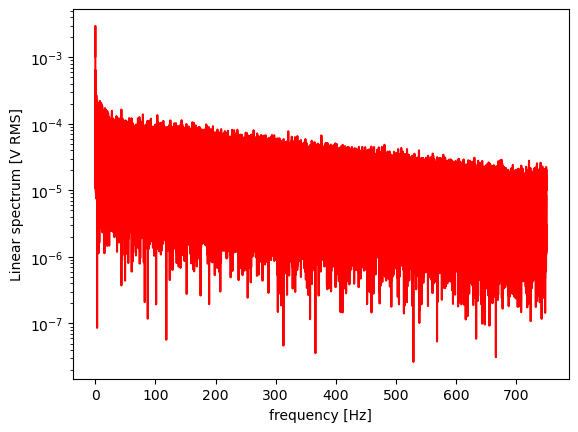

In [27]:
Pxx_spec = pd.DataFrame(columns=labels_list)
f = pd.DataFrame(columns=labels_list)
RMSamplitude = []
for label in labels_list[2:]:
    f[label], Pxx_spec[label] = sp.periodogram(normDF[label], SR, 'flattop', scaling='spectrum')

    # The peak height in the power spectrum is an estimate of the RMS amplitude.
    RMSamplitude.append(np.sqrt(Pxx_spec[label].max()))

print('Peak height of power spectrum = ' + str(round(RMSamplitude[idx_label_studied], 4)) + ' Hz')

plt.semilogy(f[label_studied], np.sqrt(Pxx_spec[label_studied]), color= 'r', label = "Power spectrum DF")
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')

### Daubechies wavelet transforms

#### Looking for the best filter

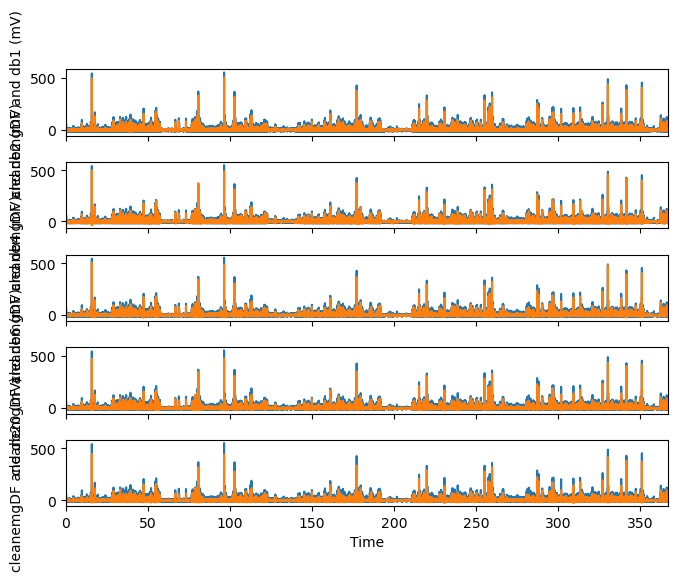

In [28]:
w1 = myfct.lowpassfilter(cleanemgDF[label_studied], thresh = 0.05, wavelet="db1")
w2 = myfct.lowpassfilter(cleanemgDF[label_studied], thresh = 0.05, wavelet="db2")
w4 = myfct.lowpassfilter(cleanemgDF[label_studied], thresh = 0.05, wavelet="db4")
w6 = myfct.lowpassfilter(cleanemgDF[label_studied], thresh = 0.05, wavelet="db6")
w20 = myfct.lowpassfilter(cleanemgDF[label_studied], thresh = 0.05, wavelet="db20")

fig, axs = plt.subplots(5, 1, sharex='col')
axs[0].plot(cleanemgDF["relative time"], cleanemgDF[label_studied], cleanemgDF["relative time"], w1, label='db4' )
axs[1].plot(cleanemgDF["relative time"], cleanemgDF[label_studied], cleanemgDF["relative time"], w2, label='db2' )
axs[2].plot(cleanemgDF["relative time"], cleanemgDF[label_studied], cleanemgDF["relative time"], w4, label='db4' )
axs[3].plot(cleanemgDF["relative time"], cleanemgDF[label_studied], cleanemgDF["relative time"], w6, label='db6' )
axs[4].plot(cleanemgDF["relative time"], cleanemgDF[label_studied], cleanemgDF["relative time"], w20, label='db20' )

axs[0].set_ylabel('cleanemgDF and db1 (mV)')
axs[1].set_ylabel('cleanemgDF and db2 (mV)')
axs[2].set_ylabel('cleanemgDF and db4 (mV)')
axs[3].set_ylabel('cleanemgDF and db6 (mV)')
axs[4].set_ylabel('cleanemgDF and db20 (mV)')

fig.tight_layout()
plt.subplots_adjust(top=0.95,
                    bottom=0.04,
                    left=0.055,
                    right=0.995,
                    hspace=0.4,
                    wspace=0.2)
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])

axs[4].set_xlabel('Time')
plt.show()

The best result is for db4 and a threashold of 0.05

#### Plotting the best filter

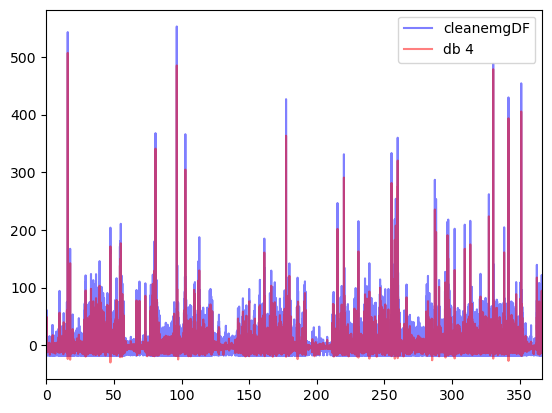

In [29]:
plt.plot(cleanemgDF["relative time"], cleanemgDF[label_studied], color= 'b', label = "cleanemgDF", alpha = 0.5)
plt.plot(cleanemgDF["relative time"], w4, color= 'r', label = "db 4", alpha = 0.5)

plt.legend()
plt.xlim([0, cleanemgDF['relative time'].iloc[-1]])
plt.show()

### Sample entropy

In [32]:
SampEnDF,_ = EH.SampEn(cleanemgDF[label_studied], m=2, r = 0.2 * np.std(cleanemgDF[label_studied])) 

MemoryError: Unable to allocate 2.20 TiB for an array with shape (550450, 550450) and data type float64